In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler
import GPy

In [2]:
os.chdir('/home/saumya/Documents/FINAL_DATA/Spec')

In [3]:
x_dat = np.load('ABS_noisy_SNR_new.npy')
# x_dat = np.reshape(x_dat, -1)[:, None]

In [4]:
x_dat.shape

(6250, 3000)

In [5]:
x_dat

array([[-7.606e-05,  1.534e-04,  2.807e-05, ...,  3.526e-04,  4.873e-04,
         2.220e-04],
       [ 8.225e-06,  1.213e-04,  9.894e-05, ...,  2.558e-04,  3.095e-04,
         2.820e-04],
       [ 1.440e-04,  1.742e-04,  2.308e-04, ...,  1.791e-04,  3.116e-04,
         2.897e-04],
       ...,
       [ 3.030e-04,  2.529e-03,  3.142e-04, ...,  4.536e-03,  4.520e-03,
         3.195e-03],
       [ 2.256e-03,  1.499e-03,  2.655e-03, ...,  1.426e-03,  2.998e-03,
         3.654e-03],
       [ 1.982e-03,  2.670e-03,  2.090e-03, ...,  1.137e-03,  6.180e-04,
         2.632e-03]], dtype=float16)

In [6]:
os.chdir('/home/saumya/Documents/FINAL_DATA/Param_profile')

In [7]:
y_dat_std = np.load('final_param.npy')

# y_dat = np.reshape(y_dat, -1)[:, None]

# y_dat = y_dat[:10000]

In [8]:
os.chdir('/home/saumya/Documents/FINAL_DATA/Model_data_noisy/ICM')

In [9]:
y_A1_T = StandardScaler().fit(np.reshape(y_dat_std[:,0],-1)[:,None])
y_A2_T = StandardScaler().fit(np.reshape(y_dat_std[:,1],-1)[:,None])
y_A3_T = StandardScaler().fit(np.reshape(y_dat_std[:,2],-1)[:,None])

In [10]:
y_A1_d = y_A1_T.transform(np.reshape(y_dat_std[:,0],-1)[:,None])
y_A2_d = y_A2_T.transform(np.reshape(y_dat_std[:,1],-1)[:,None])
y_A3_d = y_A3_T.transform(np.reshape(y_dat_std[:,2],-1)[:,None])

In [11]:
import pickle


with open('ICM_A1.pkl', 'wb') as file:
    pickle.dump(y_A1_T, file)

with open('ICM_A2.pkl', 'wb') as file:
    pickle.dump(y_A2_T, file)

with open('ICM_A3.pkl', 'wb') as file:
    pickle.dump(y_A3_T, file)

In [12]:
y_dat = np.column_stack((y_A1_d, y_A2_d, y_A3_d))

In [13]:
# import pickle

# import pickle
# with open('y_d_T_ICM.pkl', 'wb') as file:
#     pickle.dump(y_dat_transform, file)

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
def train_val_test_split(X, y, val_size):
    # test_size = 1 - train_size - val_size
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = val_size)
    # relative_train_size = train_size / (val_size + train_size)
    # X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                    #   train_size = relative_train_size, test_size = 1-relative_train_size)
    return X_train_val, X_test, y_train_val, y_test

In [16]:
X_train, X_test, Y_train, Y_test = train_val_test_split(x_dat, y_dat, .2)

In [17]:
(y_dat[2][0])

-1.6641005886756877

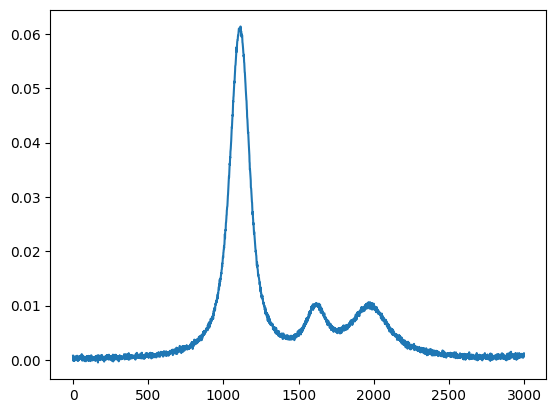

In [18]:
plt.plot(x_dat[1200])

In [19]:
max(x_dat[1200])

0.06134

In [20]:
# ICM model set up
ks = GPy.kern.RBF(np.shape(X_train)[1])
icm = GPy.util.multioutput.ICM(input_dim=np.shape(X_train)[1],num_outputs=1,kernel=ks)

In [21]:
print(icm)
# print('W matrix\n',icm.B.W)
# print('\nkappa vector\n',icm.B.kappa)
# print('\nB matrix\n',icm.B.B)

  ICM.             |         value  |  constraints  |  priors
  rbf.variance     |           1.0  |      +ve      |        
  rbf.lengthscale  |           1.0  |      +ve      |        
  B.W              |  [0.04887674]  |               |        
  B.kappa          |           0.5  |      +ve      |        


In [22]:
Y_train.shape

(5000, 3)

In [23]:
m = GPy.models.GPCoregionalizedRegression([X_train],[Y_train],kernel=icm)
m['.*rbf.var'].constrain_fixed(1.)
# constrain if converge to reasonless extrema
# m['mixed_noise.Gaussian_noise_0.variance'].constrain_bounded(0,1e-5)
# m['mixed_noise.Gaussian_noise_1.variance'].constrain_bounded(0,1e-5)
# m['mixed_noise.Gaussian_noise_2.variance'].constrain_bounded(0,1e-5)
print(m)


Name : gp
Objective : 17985.448475573776
Number of Parameters : 5
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                                    |         value  |  constraints  |  priors
  ICM.rbf.variance                       |           1.0  |   +ve fixed   |        
  ICM.rbf.lengthscale                    |           1.0  |      +ve      |        
  ICM.B.W                                |  [0.04887674]  |               |        
  ICM.B.kappa                            |           0.5  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |           1.0  |      +ve      |        


In [24]:
# print('W matrix\n',icm.B.W)
# print('\nkappa vector\n',icm.B.kappa)

In [25]:
m.optimize(messages=True)

In [26]:
with open('gpr_ICM_Norm.pkl', 'wb') as file:
    pickle.dump(m, file)

In [27]:
print(m)
# print('W matrix\n',icm.B.W)
# print('\nkappa vector\n',icm.B.kappa)
# print('\nB matrix\n',icm.B.B)


Name : gp
Objective : 14834.928260485507
Number of Parameters : 5
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                                    |                value  |  constraints  |  priors
  ICM.rbf.variance                       |                  1.0  |   +ve fixed   |        
  ICM.rbf.lengthscale                    |  0.23801892027833405  |      +ve      |        
  ICM.B.W                                |         [1.30483173]  |               |        
  ICM.B.kappa                            |   1.6009544367107644  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |   0.3606264928448099  |      +ve      |        


In [28]:
newX = X_test

In [29]:
newX = np.concatenate((newX,np.zeros((np.shape(X_test)[0],1))),1)
noise_dict = {'output_index':newX[:,-1].astype(int)}
ys_norm,var=m.predict(newX,Y_metadata=noise_dict)

# Temper_test_=scalerT.inverse_transform(ys)


In [30]:
ys_norm[:,0]

array([-0.85963514,  1.01913365, -1.44931629, ...,  0.7623728 ,
        0.02041731,  0.40912521])

In [31]:
Y_test[:,0]

array([-0.83205029,  0.97072534, -1.24807544, ...,  0.69337525,
        0.        ,  0.41602515])

In [32]:
ys = np.zeros_like(ys_norm)
Y_test_real = np.zeros_like(Y_test)

In [33]:
ys[:, 0] = y_A1_T.inverse_transform(ys_norm[:,0].reshape(-1,1)).ravel()
ys[:, 1] = y_A2_T.inverse_transform(ys_norm[:,1].reshape(-1,1)).ravel()
ys[:, 2] = y_A3_T.inverse_transform(ys_norm[:,2].reshape(-1,1)).ravel()

In [34]:
Y_test_real[:, 0] = y_A1_T.inverse_transform(Y_test[:,0].reshape(-1,1)).ravel()
Y_test_real[:, 1] = y_A2_T.inverse_transform(Y_test[:,1].reshape(-1,1)).ravel()
Y_test_real[:, 2] = y_A3_T.inverse_transform(Y_test[:,2].reshape(-1,1)).ravel()

In [35]:
ys[:,0]-Y_test_real[:,0]

array([ -3.89546033,   6.83609659, -28.41871489, ...,   9.74365762,
         2.88328041,  -0.97439085])

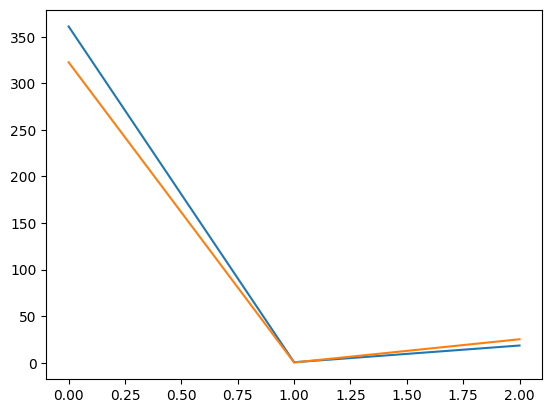

In [36]:
plt.plot(ys[1000])

plt.plot(Y_test_real[1000])

In [37]:
ys-Y_test_real

array([[ -3.89546033,  -0.43544162,   0.60428015],
       [  6.83609659,   0.47107386,  -0.12808699],
       [-28.41871489,   0.22648142,  17.08893745],
       ...,
       [  9.74365762,   0.4998888 ,  -0.94270903],
       [  2.88328041,   0.43772454,  -0.11306201],
       [ -0.97439085,  -0.45244054,   0.33925427]])

In [38]:
Y_test_real

array([[4.20500000e+02, 1.00000000e+00, 4.28775510e+01],
       [6.75083333e+02, 1.00000000e-01, 4.50816327e+01],
       [3.61750000e+02, 3.25000000e-01, 1.00000000e+00],
       ...,
       [6.35916667e+02, 1.00000000e-01, 2.41428571e+01],
       [5.38000000e+02, 1.00000000e-01, 2.52448980e+01],
       [5.96750000e+02, 1.00000000e+00, 3.07551020e+01]])

In [39]:
from sklearn import metrics

In [40]:
conc_1 = metrics.mean_squared_error(np.array(ys[:, 1]), np.array(Y_test_real[:, 1]))
print(f'The mean squared error between the real and predicted values are: {conc_1}')

The mean squared error between the real and predicted values are: 0.10617735770757299


In [41]:
conc_1 = metrics.mean_squared_error(np.array(ys[:, 2]), np.array(Y_test_real[:, 2]))
print(f'The mean squared error between the real and predicted values are: {conc_1}')

The mean squared error between the real and predicted values are: 35.37835613219934


In [42]:
conc_1 = metrics.mean_squared_error(np.array(ys[:, 0]), np.array(Y_test_real[:, 0]))
print(f'The mean squared error between the real and predicted values are: {conc_1}')

The mean squared error between the real and predicted values are: 555.5274199787003


In [43]:
metrics.mean_squared_error(ys, Y_test_real)

197.0039844895356

In [44]:
np.save("true_vals_icm", Y_test_real)

In [45]:
np.save("pred_vals_icm", ys)
